In [1]:
%%capture
!pip install pydantic --upgrade
!pip install faker bidict networkx matplotlib pandas numpy tqdm

from bidict import bidict

from typing import Dict, Any, Type, List, Protocol, Tuple
from pydantic import BaseModel

from faker import Faker
import random

import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import queue

from time import perf_counter
from tqdm import tqdm

import multiprocessing

In [2]:
class Vertexiable(Protocol):
    """
    Definição de um procolo que define a inteface para
    um tipo de dado que será armazenado em um vértice.
    """

    def __hash__(self):
        pass

    def representation(self):
        pass


class Person(BaseModel):
    """
    Classe que representa uma pessoa. O intuito dela é
    puramente ter uma aplicação mais clara para os grafos,
    que neste caso representam uma rede de contatos.
    """

    name: str
    email: str
    age: int
    phone: str

    def __hash__(self):
        """
        Função que garante que uma pessoa seja única no nosso grafo
        """
        return hash(self.email)

    def representation(self):
        return self.name


class SimplifiedPerson(BaseModel):
    """
    Classe que representa o vértice mais simples possível
    """

    name: str

    def __hash__(self):
        return hash(self.name)

    @property
    def representation(self):
        return self.name


def create_people(num_people: int) -> List[Person]:
    """
    Função de seed parametrizável para gerar novas pessoas na rede
    """
    fake = Faker()
    people = []
    for _ in range(num_people):
        person = Person(
            name=fake.first_name(),
            email=fake.email(),
            age=fake.random_int(min=18, max=100, step=1),
            phone=fake.phone_number(),
        )
        people.append(person)
    return people


class Vertex(BaseModel):
    """
    Classe de um vértice, o tipo de dado é abstraído dentro
    de um atributo 'data'.

    A utilização de sets para armazenamento de vértices adjascentes
    é para garantir tempo de busca constante

    O tipo Type["nome da classe"] é uma técnica de referencia adiantada.
    Ela permite referenciar o tipo da própria classe
    """

    data: Any

    def __hash__(self):
        return self.data.__hash__()

    @property
    def representation(self):
        return self.data.representation


class Graph(BaseModel):
    vertices: set = set()

    edges: dict = dict()
    max_vertices: int = 20

    def add_vertex(self, vertex: Vertex):
        if len(self.vertices) == self.max_vertices:
            raise OverflowError("Too many vertices, wont include a new one")

        self.vertices.add(vertex)

    def remove_vertex(self, to_remove_vertex: Vertex):
        if to_remove_vertex not in self.vertices:
            raise ValueError("Vertex not found")

        self.vertices.remove(to_remove_vertex)
        for vertex in self.vertices:
            vertex.remove_adjacent(to_remove_vertex)

    def add_edge(self, a: Vertex, b: Vertex, weight: int):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        self.edges[frozenset([a, b])] = weight

    def remove_edge(self, a: Vertex, b: Vertex):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        self.edges.pop(frozenset([a, b]))

    def is_adjacent(self, a: Vertex, b: Vertex):
        if a not in self.vertices or b not in self.vertices:
            raise ValueError("Vertex not found")

        return frozenset([a, b]) in self.edges

    def contains(self, vertex: Vertex) -> bool:
        return vertex in self.vertices

    def get_vertices(self) -> set:
        return self.vertices

    def get_edges(self) -> dict:
        return self.edges

    def get_adjascent(self, vertex) -> list:
        adjascent = {}
        for v in self.vertices:
            if frozenset([vertex, v]) in self.edges:
                adjascent[frozenset([vertex, v])] = self.edges[frozenset([vertex, v])]
        return adjascent

    def plot(self, node_size: int = 3000) -> None:
        """
        Utiliza uma lib de grafos para plotar nossa implementação hahah,
        nós convertemos um grafo em outro tipo e por isso conseguimos fazer isso.
        """
        graph = nx.Graph()
        for vertex in self.get_vertices():
            graph.add_node(vertex.representation)

        for edge, weight in self.get_edges().items():
            a, b = list(edge)
            graph.add_edge(a.representation, b.representation, weight=weight)
        pos = nx.random_layout(graph)
        edges = graph.edges()
        weights = [graph[u][v]["weight"] for u, v in edges]
        nx.draw(
            graph,
            pos,
            with_labels=True,
            edge_color="red",
            width=weights,
            node_size=node_size,
        )

    def plot_path(self, path, node_size: int = 3000):
        """
        Utiliza uma lib de grafos para plotar nossa implementação hahah,
        nós convertemos um grafo em outro tipo e por isso conseguimos fazer isso.
        """
        path_pairs = {
            frozenset([path[i].representation, path[i + 1].representation])
            for i in range(len(path) - 1)
        }

        graph = nx.Graph()
        for vertex in self.get_vertices():
            graph.add_node(vertex.representation)

        for edge, weight in self.get_edges().items():
            a, b = list(edge)
            graph.add_edge(a.representation, b.representation, weight=weight)

        pos = nx.random_layout(graph)
        edges = graph.edges()
        weights = [graph[u][v]["weight"] for u, v in edges]
        colors = ["blue" if frozenset(e) in path_pairs else "red" for e in edges]
        nx.draw(
            graph,
            pos,
            with_labels=True,
            edge_color=colors,
            width=weights,
            node_size=node_size,
        )


def kruskal_mst(graph: Graph) -> Graph:
    """ Essa função assume que o grafo é conexo"""
    def find(parent: List[int], i: int) -> int:
        """
        Função que acha o pai de um vertice recursivamente
        """
        if parent[i] == -1:
            return i
        return find(parent, parent[i])

    def union(parent: List[int], x: int, y: int) -> None:
        """
        Função de define a união entre dois conjuntos disjuntos.

        A noção intuítiva dela é: dado dois conjuntos disjuntos,
        faça o elemento x ser o pai de y, ou seja, adiciona ele
        no conjunto
        """
        parent[x] = y

    # Cria o grafo de saída contendo todos os vértices do grafo de entrada
    mst = Graph(vertices=set(graph.vertices))

    # Cria uma lista que indica o pai de cada um dos vértices do grafo
    parents = [-1] * len(graph.vertices)

    # Ordena as arestas por peso de forma ascendente
    edges = sorted(graph.get_edges().items(), key=lambda x: x[1])

    min_edge_index = 0
    # Enquanto ainda não adicionamos n-1 arestas na mst
    while len(mst.get_edges()) < len(graph.vertices) - 1:
        ((u, v), weight) = edges[min_edge_index]
        min_edge_index += 1

        parent_of_x = find(parents, list(graph.vertices).index(u))
        parent_of_y = find(parents, list(graph.vertices).index(v))

        # Se os dois pais são diferentes, os dois não estão no mesmo conjunto disjunto
        if parent_of_x != parent_of_y:
            # Adiciona a nova aresta na mst
            mst.add_edge(u, v, weight)
            # O pai de x vira pai de y por estarem no mesmo conjunto agora
            union(parents, parent_of_x, parent_of_y)

    return mst

def dijkstra(graph, start, end) -> Tuple[int, List[Vertex]]:
    class PriorityItem:
        "Classe criada para facilitar a manipulação da pq"

        def __init__(self, priority, data):
            self.priority = priority
            self.data = data

        def __lt__(self, other):
            return self.priority < other.priority

    distances = {vertex: float("inf") for vertex in graph.get_vertices()}
    distances[start] = 0

    previous = {vertex: None for vertex in graph.get_vertices()}

    pq = queue.PriorityQueue()
    pq.put(PriorityItem(0, start))
    while not pq.empty():
        item = pq.get()
        curr_dist, curr_vertex = item.priority, item.data

        if curr_dist > distances[curr_vertex]:
            continue

        for edge, weight in graph.get_adjascent(curr_vertex).items():
            a, b = edge
            adj_vertex = a if curr_vertex == b else b
            new_dist = curr_dist + weight
            if new_dist < distances[adj_vertex]:
                distances[adj_vertex] = new_dist
                previous[adj_vertex] = curr_vertex
                pq.put(PriorityItem(distances[adj_vertex], adj_vertex))

    if previous[end] is None:
        return float("inf"), []

    path = [end]
    while path[-1] != start:
        path.append(previous[path[-1]])
    path.reverse()

    return distances[end], path

def read_df_from_google_sheets(url: str) -> pd.DataFrame:
    url = url.replace("/edit#gid=", "/export?format=csv&gid=")
    return pd.read_csv(url).fillna(0)


def get_adjacency_matrix_from_google_sheets(url: str) -> np.array:
    sheet = read_df_from_google_sheets(url)

    col_names = sheet.columns.values
    return np.vstack([col_names, sheet.to_numpy()])


def get_name_map_from_adjacency_matrix(adjacency_matrix: np.array) -> dict:
    return {i + 1: name for i, name in enumerate(adjacency_matrix[1:, 0])}


def get_edges_from_adjacency_matrix(adjacency_matrix: np.array) -> set:
    """
    Função que encontra todas as arestas existentes entre os vértices
    """
    name_map = get_name_map_from_adjacency_matrix(adjacency_matrix)

    edges = set()
    for pair in zip(*np.where(adjacency_matrix[1:, 1:].astype(int) > 0)):
        ordered_pair = sorted(pair)

        ordered_pair = map(lambda x: name_map[x + 1], ordered_pair)
        edges.add(tuple(ordered_pair))

    return edges


def read_people_graph_from_sheets(sheets_url) -> Graph:
    adjacency_matrix = get_adjacency_matrix_from_google_sheets(sheets_url)
    edges = get_edges_from_adjacency_matrix(adjacency_matrix)
    name_map = get_name_map_from_adjacency_matrix(adjacency_matrix)

    graph = Graph()
    vertices = bidict()
    for name in name_map.values():
        person = SimplifiedPerson(name=name)
        vertex = Vertex(data=person)
        graph.add_vertex(vertex)

        vertices[name] = vertex

    name_map = bidict(name_map)
    for name_a, name_b in edges:
        row, col = name_map.inverse[name_a], name_map.inverse[name_b]
        graph.add_edge(
            vertices[name_a], vertices[name_b], weight=(adjacency_matrix[row, col])
        )
    return graph

def test_avg_search_wait_time(graph: Graph, pairs: List[Vertex], search_algo=dijkstra, n_repeats: int = 1000) -> float: 
  pb = tqdm(range(n_repeats*len(pairs)), desc=f"Rodando baterias de testes", position=0, leave=True)
  wait_times = []
  for _ in range(n_repeats):
    for i, pair in enumerate(pairs):
      begin = perf_counter()
      search_algo(graph, *pair)
      end = perf_counter()
      wait_times.append(end-begin)
      pb.update(1)
  return sum(wait_times)/len(wait_times)

## Carrega o grafo de uma matriz de adjascência no Google Sheets

In [3]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/11rUFD4bh81mYtqmE3mK8aAvxsCmQ98hLKtLTEHn0v8Q/edit#gid=0"

read_df_from_google_sheets(SHEET_URL)

,Person,Rafael,Jean,Rodrigo,Guilherme,Theago,Maria,José,Ítalo,Roberta,...,Ana,Carl,Charles,Pedro,Juvenal,Mohamed,Joana,Carla,Annita,Shakira
0,Rafael,0.0,4.0,1.0,5.0,6.0,1.0,1.0,0.0,7.0,...,5.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
1,Jean,4.0,0.0,0.0,4.0,9.0,0.0,4.0,2.0,0.0,...,5.0,0.0,2.0,4.0,0.0,0.0,7.0,0.0,8.0,0.0
2,Rodrigo,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0
3,Guilherme,5.0,4.0,0.0,0.0,5.0,1.0,5.0,6.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Theago,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Maria,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,José,1.0,4.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,Ítalo,0.0,2.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Roberta,7.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Eduardo,1.0,4.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


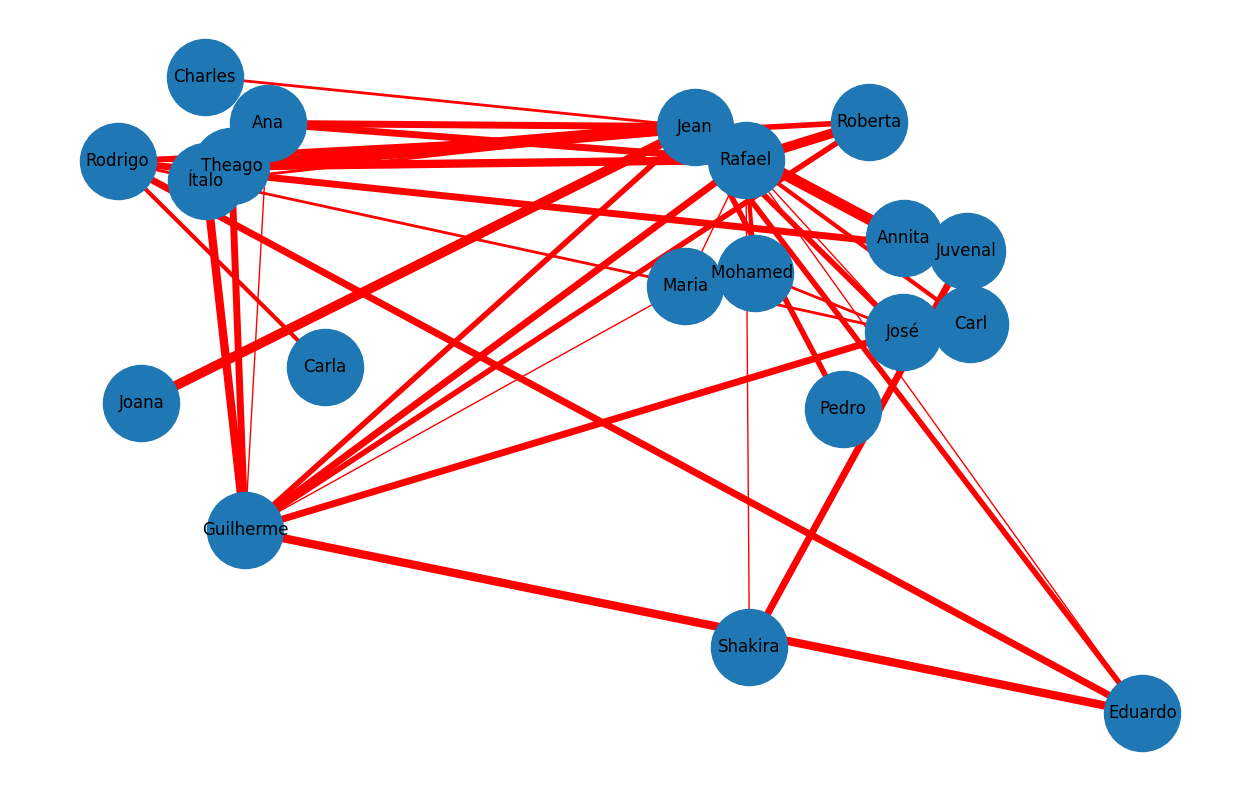

In [4]:
social_network = read_people_graph_from_sheets(SHEET_URL)

fig, ax = plt.subplots(figsize=(16, 10))
social_network.plot()
plt.show()

# Algoritmo de Kruskall

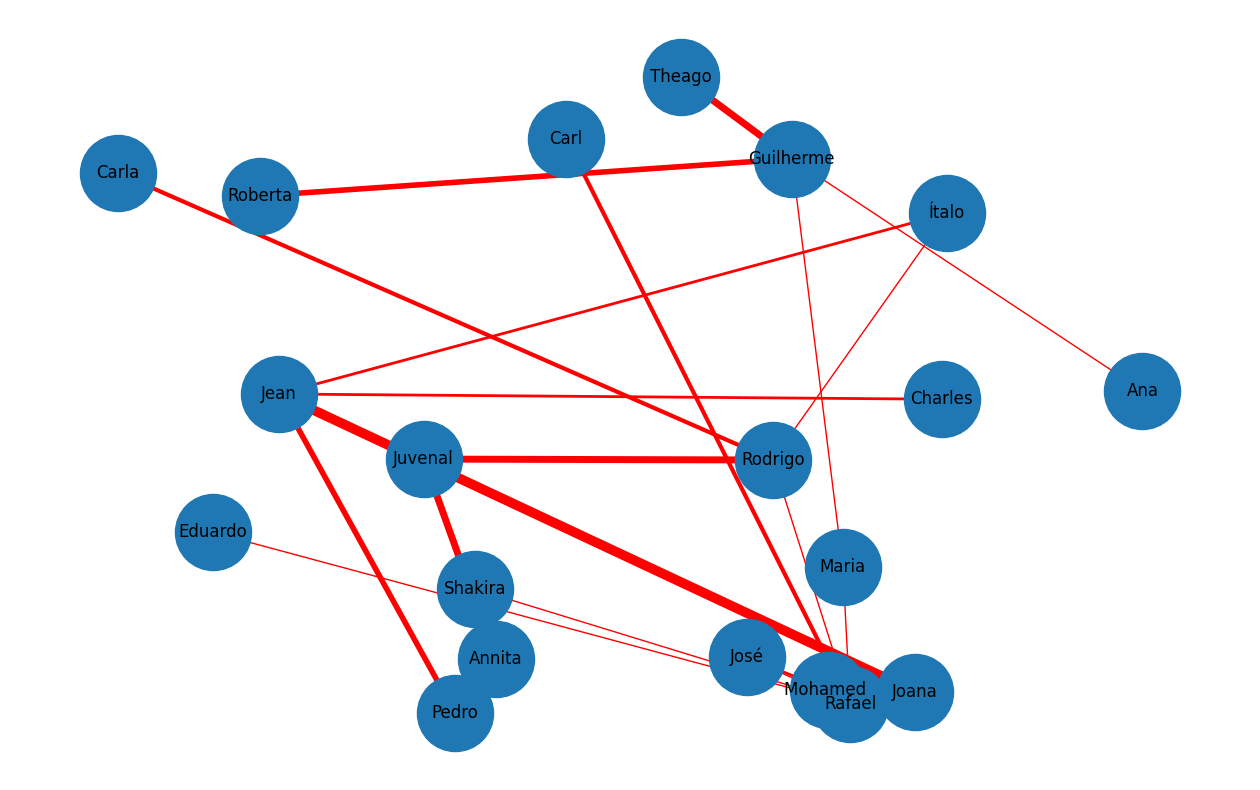

In [5]:
mst = kruskal_mst(social_network)

fig, ax = plt.subplots(figsize=(16, 10))
mst.plot()
plt.show()

In [8]:
N_NODES = 1000
N_PAIRS = 500
N_REPEATS = 2

social_network = Graph(max_vertices=N_NODES)

vertices = []
for i in range(N_NODES):
  v = Vertex(data=SimplifiedPerson(name=f"{i}"))
  social_network.add_vertex(v)
  vertices.append(v)

for i, u in enumerate(vertices[:len(vertices)-1]):
  for v in vertices[i+1:]:
    social_network.add_edge(v, u, weight=random.uniform(1, 100))

mst = kruskal_mst(social_network)

Rodando baterias de testes: 100%|███████████| 1000/1000 [07:31<00:00,  2.22it/s]


Tempo medio de busca no grafo original: 12.66897119152294
Tempo medio de busca na mst: 0.4504721580180194
Fator de aceleracao da mst/original:  28.124


Computando erro absoluto entre distancias: 100%|█| 500/500 [1:49:17<00:00, 13.11


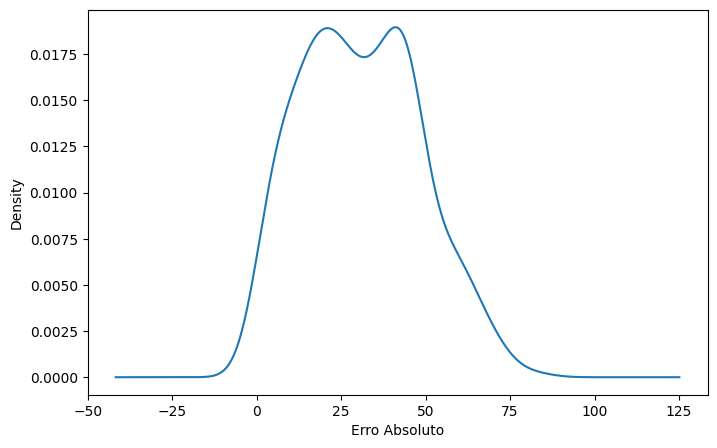

In [9]:
pairs = [random.choices(list(social_network.vertices), k=2) for _ in range(N_PAIRS)] 

avg_original_graph_search_time = test_avg_search_wait_time(social_network, pairs, n_repeats=N_REPEATS)
avg_mst_graph_search_time = test_avg_search_wait_time(mst, pairs, n_repeats=N_REPEATS)

print(f"Tempo medio de busca no grafo original: {avg_original_graph_search_time}")
print(f"Tempo medio de busca na mst: {avg_mst_graph_search_time}")
print(f"Fator de aceleracao da mst/original: {avg_original_graph_search_time/avg_mst_graph_search_time: .3f}")

errors = []
for pair in tqdm(pairs, desc="Computando erro absoluto entre distancias", position=0, leave=True):
  nodes_distance_original, _ = dijkstra(social_network, *pair)
  nodes_distance_mst, _ = dijkstra(mst, *pair)
  errors.append(abs(nodes_distance_original - nodes_distance_mst))

fig, ax = plt.subplots(figsize=(8, 5))
ax = pd.Series(errors).plot.kde()
ax.set_xlabel("Erro Absoluto")

plt.show()

In [10]:
for (u, v), weight in mst.get_edges().items():
    print(f"{u.representation:>10} <---{weight}---> {v.representation:<10}")

       273 <---1.000050086404439---> 558       
       653 <---1.0000840464077714---> 861       
        52 <---1.0003960186031804---> 93        
       553 <---1.0004214962799527---> 362       
        62 <---1.0004729017349814---> 255       
       447 <---1.0006347682847692---> 904       
       349 <---1.0014162711256769---> 203       
       332 <---1.0014379845837496---> 598       
       556 <---1.0014937332367886---> 967       
        58 <---1.001833429721271---> 302       
       136 <---1.0021361713773451---> 980       
       327 <---1.002285149913061---> 979       
       155 <---1.0024322210996952---> 303       
       718 <---1.003066446084868---> 9         
       396 <---1.0033598592312774---> 559       
       194 <---1.0035663733245666---> 868       
       317 <---1.0036500807954363---> 200       
       320 <---1.0040682831190053---> 275       
       131 <---1.0045689759088121---> 762       
       211 <---1.004704974020941---> 284       
        53 <---1.00489648